In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.metrics import mean_squared_error,r2_score

In [3]:
df=pd.read_excel('Train_dataset.xlsx')
df.head(10)

,Stock Index,Index,Industry,VWAP,General Index,NAV,P/E Ratio,Volumes Traded,Inventory Turnover,Covid Impact (Beta),Tracking Error,Dollar Exchange Rate,Put-Call Ratio,P/B Ratio,Stock Price
0,AA1,NYSE,Real Estate,700.29,12765.84,32.38,45.35,1208599.0,5.05,-0.43,0.0520,1.0,0.61,9.20,156.987852
1,AA2,NYSE,Information Tech,214.52,12765.84,33.25,170.56,13753356.0,3.10,0.23,0.0164,1.0,NaN,6.91,560.859622
2,AA3,NYSE,Information Tech,943.42,12765.84,88.27,143.58,6892003.0,7.70,0.23,0.0396,1.0,NaN,6.09,1279.732874
3,AA4,BSE,Materials,828.13,38182.08,73.66,151.76,8316793.0,4.80,0.03,0.0431,74.9,1.11,5.60,1121.787632
4,AA5,S&P 500,Real Estate,NaN,3351.28,23.79,NaN,3943312.0,8.06,-0.43,0.0244,1.0,1.07,9.46,382.962534
5,AA6,BSE,Materials,259.61,38182.08,10.63,153.05,19263869.0,8.04,0.03,0.0344,74.9,1.15,5.51,158.687016
6,AA7,NYSE,Healthcare,635.37,12765.84,67.21,29.63,7086103.0,5.87,0.78,0.0186,1.0,0.75,8.60,209.645870
7,AA8,NSE,Real Estate,187.43,11270.15,NaN,89.69,NaN,NaN,-0.43,0.0370,74.9,0.78,6.73,861.481269
8,AA9,NSE,Materials,950.81,11270.15,31.50,159.58,1361019.0,2.72,0.03,0.0534,74.9,1.22,6.46,514.240811
9,AA10,JSE,Healthcare,961.02,55722.00,72.16,29.61,14385395.0,7.87,0.78,0.0292,NaN,1.21,4.42,239.085804


In [4]:
df.shape

(7383, 15)

In [5]:
df.isnull().sum()

Stock Index               0
Index                     0
Industry                  0
VWAP                     38
General Index            62
NAV                      61
P/E Ratio               234
Volumes Traded          268
Inventory Turnover      399
Covid Impact (Beta)     376
Tracking Error           71
Dollar Exchange Rate     77
Put-Call Ratio           85
P/B Ratio                25
Stock Price               0
dtype: int64

In [6]:
#Convert indusrty categories to numeric values
def get_industry_code(df):
    industry={
        "Energy":0,
        "Healthcare":1,
        "Information Tech":2,
        "Materials":3,
        "Real Estate":4
    }
    id_code=[]
    for ind in df['Industry']:
        id_code.append(industry[ind])
    df['Industry_Code']=pd.DataFrame(id_code)
    
get_industry_code(df)
df.head()

,Stock Index,Index,Industry,VWAP,General Index,NAV,P/E Ratio,Volumes Traded,Inventory Turnover,Covid Impact (Beta),Tracking Error,Dollar Exchange Rate,Put-Call Ratio,P/B Ratio,Stock Price,Industry_Code
0,AA1,NYSE,Real Estate,700.29,12765.84,32.38,45.35,1208599.0,5.05,-0.43,0.0520,1.0,0.61,9.20,156.987852,4
1,AA2,NYSE,Information Tech,214.52,12765.84,33.25,170.56,13753356.0,3.10,0.23,0.0164,1.0,NaN,6.91,560.859622,2
2,AA3,NYSE,Information Tech,943.42,12765.84,88.27,143.58,6892003.0,7.70,0.23,0.0396,1.0,NaN,6.09,1279.732874,2
3,AA4,BSE,Materials,828.13,38182.08,73.66,151.76,8316793.0,4.80,0.03,0.0431,74.9,1.11,5.60,1121.787632,3
4,AA5,S&P 500,Real Estate,NaN,3351.28,23.79,NaN,3943312.0,8.06,-0.43,0.0244,1.0,1.07,9.46,382.962534,4


In [7]:
#fill nan with mean values
def fill_values(df):
    df['General Index'] = df.groupby('Industry')['General Index'].transform(lambda x: x.fillna(x.mean()))
    df['NAV'] = df.groupby('Industry')['NAV'].transform(lambda x: x.fillna(x.mean()))
    df['VWAP'] = df.groupby('Industry')['VWAP'].transform(lambda x: x.fillna(x.mean()))
    df['Volumes Traded'] = df.groupby('Industry')['Volumes Traded'].transform(lambda x: x.fillna(x.mean()))
    df['Inventory Turnover'] = df.groupby('Industry')['Inventory Turnover'].transform(lambda x: x.fillna(x.mean()))
    df['Tracking Error'] = df.groupby('Industry')['Tracking Error'] .transform(lambda x: x.fillna(x.mean()))
    df['Dollar Exchange Rate'] = df.groupby('Index')['Dollar Exchange Rate'].transform(lambda x: x.fillna(x.max()))
    df['P/E Ratio'] = df.groupby('Industry')['P/E Ratio'] .transform(lambda x: x.fillna(x.mean()))
    df['Covid Impact (Beta)']=df.groupby('Industry')['Covid Impact (Beta)'] .transform(lambda x: x.fillna(x.mean()))

fill_values(df)

In [8]:
#add some extra columns
def add_cols(df):
    mean_vwap=df.groupby('Industry_Code',as_index=False)['VWAP'].mean()
    mean_pe_ratio=df.groupby('Industry_Code',as_index=False)['P/E Ratio'].mean()
    mean_pb_ratio=df.groupby('Industry_Code',as_index=False)['P/B Ratio'].mean()
    mean_volume=df.groupby('Industry_Code',as_index=False)['Volumes Traded'].mean()
    mean_beta=df.groupby('Industry_Code',as_index=False)['Covid Impact (Beta)'].mean()
    mean_putcall=df.groupby('Industry_Code',as_index=False)['Put-Call Ratio'].mean()

    full_pe_ratio=df['P/E Ratio'].mean()
    full_vwap=df['VWAP'].mean()

    n=len(df)
    delta_fullvwap=[]
    delta_industry_vwap=[]

    for i in range(n):
        vwap=df['VWAP'][i]
        delta_fullvwap.append(vwap-full_vwap)
        k=df['Industry_Code'][i]
        avg=mean_vwap['VWAP'][k]
        delta_industry_vwap.append(vwap-avg)

    df['delta_full_vwap']=pd.DataFrame(delta_fullvwap)
    df['delta_vwap']=pd.DataFrame(delta_industry_vwap)
    
    delta_full_pe=[]
    delta_industry_pe=[]

    for i in range(n):
        pe=df['P/E Ratio'][i]
        delta_full_pe.append(pe-full_pe_ratio)
        k=df['Industry_Code'][i]
        avg=mean_pe_ratio['P/E Ratio'][k]
        delta_industry_pe.append(pe-avg)

    df['delta_full_pe']=pd.DataFrame(delta_full_pe)
    df['delta_pe']=pd.DataFrame(delta_industry_pe)

    delta_pb=[]
    delta_volume=[]
    delta_covid=[]
    delta_putcall=[]

    df['P/B Ratio']=df['P/B Ratio'].fillna(0)
    df['Put-Call Ratio']=df['Put-Call Ratio'].fillna(0.7)

    for i in range(n):
        pb=df['P/B Ratio'][i]
        vol=df['Volumes Traded'][i]
        beta=df['Covid Impact (Beta)'][i]
        putcall=df['Put-Call Ratio'][i]
        k=df['Industry_Code'][i]

        avg=mean_pb_ratio['P/B Ratio'][k]
        delta_pb.append(avg-pb)

        avg=mean_volume['Volumes Traded'][k]
        delta_volume.append(avg-vol)

        avg=mean_beta['Covid Impact (Beta)'][k]
        delta_covid.append(avg-beta)

        avg=mean_putcall['Put-Call Ratio'][k]
        delta_putcall.append(avg-putcall)

    df['delta_pb']=pd.DataFrame(delta_pb)
    df['delta_volume']=pd.DataFrame(delta_volume)
    df['delta_covid']=pd.DataFrame(delta_covid)
    df['delta_putcall']=pd.DataFrame(delta_putcall)

In [9]:
add_cols(df)

In [10]:
df.head(10)

,Stock Index,Index,Industry,VWAP,General Index,NAV,P/E Ratio,Volumes Traded,Inventory Turnover,Covid Impact (Beta),...,Stock Price,Industry_Code,delta_full_vwap,delta_vwap,delta_full_pe,delta_pe,delta_pb,delta_volume,delta_covid,delta_putcall
0,AA1,NYSE,Real Estate,700.290000,12765.84,32.380000,45.350000,1.208599e+06,5.05000,-0.43,...,156.987852,4,214.097990,2.045673e+02,-60.194575,-5.931049e+01,-4.208266,9.072560e+06,4.829470e-15,0.330988
1,AA2,NYSE,Information Tech,214.520000,12765.84,33.250000,170.560000,1.375336e+07,3.10000,0.23,...,560.859622,2,-271.672010,-2.713579e+02,65.015425,6.494791e+01,-1.841513,-3.341486e+06,7.771561e-16,0.251270
2,AA3,NYSE,Information Tech,943.420000,12765.84,88.270000,143.580000,6.892003e+06,7.70000,0.23,...,1279.732874,2,457.227990,4.575421e+02,38.035425,3.796791e+01,-1.021513,3.519867e+06,7.771561e-16,0.251270
3,AA4,BSE,Materials,828.130000,38182.08,73.660000,151.760000,8.316793e+06,4.80000,0.03,...,1121.787632,3,341.937990,3.450714e+02,46.215425,4.545210e+01,-0.638833,2.081485e+06,6.418477e-16,-0.164920
4,AA5,S&P 500,Real Estate,495.722747,3351.28,23.790000,104.660489,3.943312e+06,8.06000,-0.43,...,382.962534,4,9.530738,5.684342e-14,-0.884086,-5.684342e-14,-4.468266,6.337847e+06,4.829470e-15,-0.129012
5,AA6,BSE,Materials,259.610000,38182.08,10.630000,153.050000,1.926387e+07,8.04000,0.03,...,158.687016,3,-226.582010,-2.234486e+02,47.505425,4.674210e+01,-0.548833,-8.865591e+06,6.418477e-16,-0.204920
6,AA7,NYSE,Healthcare,635.370000,12765.84,67.210000,29.630000,7.086103e+06,5.87000,0.78,...,209.645870,1,149.177990,1.547508e+02,-75.914575,-7.580163e+01,-3.621921,3.435774e+06,-2.087219e-14,0.192286
7,AA8,NSE,Real Estate,187.430000,11270.15,55.352483,89.690000,1.028116e+07,5.35288,-0.43,...,861.481269,4,-298.762010,-3.082927e+02,-15.854575,-1.497049e+01,-1.738266,1.862645e-09,4.829470e-15,0.160988
8,AA9,NSE,Materials,950.810000,11270.15,31.500000,159.580000,1.361019e+06,2.72000,0.03,...,514.240811,3,464.617990,4.677514e+02,54.035425,5.327210e+01,-1.498833,9.037259e+06,6.418477e-16,-0.274920
9,AA10,JSE,Healthcare,961.020000,55722.00,72.160000,29.610000,1.438540e+07,7.87000,0.78,...,239.085804,1,474.827990,4.804008e+02,-75.934575,-7.582163e+01,0.558079,-3.863518e+06,-2.087219e-14,-0.267714


In [11]:
def get_X(df):
    X=df[[
         'VWAP',
          'NAV',
          'P/E Ratio',
          'Volumes Traded',
          'Inventory Turnover',
          'Covid Impact (Beta)',
          'Tracking Error',
          'Dollar Exchange Rate',
          'Put-Call Ratio',
          'P/B Ratio',
          'Industry_Code',
          'delta_full_vwap',
          'delta_full_pe',
          'delta_vwap',
          'delta_pe',
          'delta_pb',
          'delta_volume',
          'delta_covid',
          'delta_putcall'
         ]]
    return X

X=get_X(df)    
y=df['Stock Price']

X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42,shuffle=True,test_size=0.3) # 70% training and 30% test
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
model = GradientBoostingRegressor(**params)
model.fit(X_train,y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=500)

In [12]:
model_score = model.score(X_train,y_train)
# Have a look at R sq to give an idea of the fit ,
# Explained variance score: 1 is perfect prediction
print('R2 sq: ',model_score)
y_predicted = model.predict(X_test)

# The mean squared error
print("Mean squared error: %.2f"% mean_squared_error(y_test, y_predicted))
# Explained variance score: 1 is perfect prediction
print('Test Variance score: %.2f' % r2_score(y_test, y_predicted))


R2 sq:  0.9758334918428397
Mean squared error: 4669.10
Test Variance score: 0.97


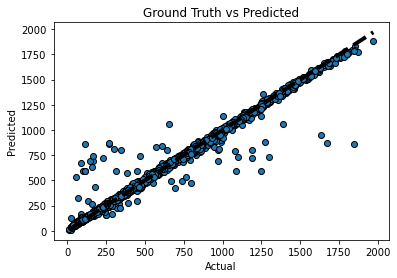

In [13]:
from sklearn.model_selection import cross_val_predict

fig, ax = plt.subplots()
ax.scatter(y_test, y_predicted, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Ground Truth vs Predicted")
plt.show()

In [14]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingRegressor(n_estimators=30, learning_rate=learning_rate)
    gb_clf.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test)))


Learning rate:  0.05
Accuracy score (training): 0.890
Accuracy score (validation): 0.889
Learning rate:  0.075
Accuracy score (training): 0.945
Accuracy score (validation): 0.945
Learning rate:  0.1
Accuracy score (training): 0.963
Accuracy score (validation): 0.964
Learning rate:  0.25
Accuracy score (training): 0.972
Accuracy score (validation): 0.969
Learning rate:  0.5
Accuracy score (training): 0.974
Accuracy score (validation): 0.965
Learning rate:  0.75
Accuracy score (training): 0.973
Accuracy score (validation): 0.960
Learning rate:  1
Accuracy score (training): 0.974
Accuracy score (validation): 0.955


In [15]:
gb_clf = GradientBoostingRegressor(n_estimators=30, learning_rate=0.5)
gb_clf.fit(X_train, y_train)    

GradientBoostingRegressor(learning_rate=0.5, n_estimators=30)

In [30]:
df1=pd.read_excel('Test_dataset.xlsx')
df1.head(10)

,Stock Index,Index,Industry,VWAP,General Index,NAV,P/E Ratio,Volumes Traded,Inventory Turnover,Covid Impact (Beta),Tracking Error,Dollar Exchange Rate,Put-Call Ratio,P/B Ratio
0,AC3235,NSE,Materials,53.30,11270.15,44.59,185.09,12067855.0,2.78,0.03,0.0330,74.9,0.80,4.66
1,AC3236,JSE,Energy,749.34,55722.00,74.20,34.01,6172474.0,6.78,0.11,0.0464,17.7,0.86,6.11
2,AC3237,S&P 500,Information Tech,567.75,3351.28,88.41,177.40,17472488.0,4.36,0.23,0.0401,1.0,0.93,4.99
3,AC3238,NSE,Healthcare,646.78,11270.15,79.36,105.44,15553159.0,2.77,0.78,0.0187,74.9,1.09,1.26
4,AC3239,NYSE,Materials,380.33,12765.84,19.90,139.40,12525784.0,5.93,0.03,0.0261,1.0,NaN,6.18
5,AC3240,NSE,Healthcare,301.09,11270.15,25.27,149.36,9878930.0,8.17,0.78,0.0233,74.9,NaN,1.12
6,AC3241,BSE,Materials,227.28,38182.08,38.50,193.01,4934899.0,4.91,0.03,0.0265,74.9,1.23,4.60
7,AC3242,S&P 500,Real Estate,NaN,NaN,73.40,121.63,4070029.0,6.11,-0.43,0.0504,1.0,1.00,4.72
8,AC3243,NSE,Energy,NaN,NaN,54.33,169.47,13609149.0,4.93,0.11,0.0609,74.9,1.00,3.96
9,AC3244,NSE,Healthcare,727.98,11270.15,99.59,139.23,12499327.0,4.65,0.78,0.0206,74.9,1.07,2.58


In [31]:
get_industry_code(df1)
fill_values(df1)
add_cols(df1)

In [32]:
df1.head(10)

,Stock Index,Index,Industry,VWAP,General Index,NAV,P/E Ratio,Volumes Traded,Inventory Turnover,Covid Impact (Beta),...,P/B Ratio,Industry_Code,delta_full_vwap,delta_vwap,delta_full_pe,delta_pe,delta_pb,delta_volume,delta_covid,delta_putcall
0,AC3235,NSE,Materials,53.300000,11270.150000,44.59,185.09,12067855.0,2.78,0.03,...,4.66,3,-435.266946,-4.243491e+02,80.375654,83.104264,0.338269,-1.710601e+06,-2.428613e-17,0.152004
1,AC3236,JSE,Energy,749.340000,55722.000000,74.20,34.01,6172474.0,6.78,0.11,...,6.11,0,260.773054,2.598246e+02,-70.704346,-71.163707,-0.992170,4.253182e+06,-4.857226e-16,0.076672
2,AC3237,S&P 500,Information Tech,567.750000,3351.280000,88.41,177.40,17472488.0,4.36,0.23,...,4.99,2,79.183054,7.140922e+01,72.685654,73.962239,-0.007538,-7.359462e+06,-6.938894e-16,0.007121
3,AC3238,NSE,Healthcare,646.780000,11270.150000,79.36,105.44,15553159.0,2.77,0.78,...,1.26,1,158.213054,1.531184e+02,0.725654,-5.017133,3.593776,-5.427500e+06,-1.298961e-14,-0.156157
4,AC3239,NYSE,Materials,380.330000,12765.840000,19.90,139.40,12525784.0,5.93,0.03,...,6.18,3,-108.236946,-9.731908e+01,34.685654,37.414264,-1.181731,-2.168530e+06,-2.428613e-17,0.252004
5,AC3240,NSE,Healthcare,301.090000,11270.150000,25.27,149.36,9878930.0,8.17,0.78,...,1.12,1,-187.476946,-1.925716e+02,44.645654,38.902867,3.733776,2.467294e+05,-1.298961e-14,0.233843
6,AC3241,BSE,Materials,227.280000,38182.080000,38.50,193.01,4934899.0,4.91,0.03,...,4.60,3,-261.286946,-2.503691e+02,88.295654,91.024264,0.398269,5.422355e+06,-2.428613e-17,-0.277996
7,AC3242,S&P 500,Real Estate,485.510494,25716.190694,73.40,121.63,4070029.0,6.11,-0.43,...,4.72,4,-3.056452,-5.684342e-14,16.915654,18.976380,0.331094,5.820017e+06,-5.329071e-15,-0.065095
8,AC3243,NSE,Energy,489.515444,25558.504533,54.33,169.47,13609149.0,4.93,0.11,...,3.96,0,0.948498,1.136868e-13,64.755654,64.296293,1.157830,-3.183493e+06,-4.857226e-16,-0.063328
9,AC3244,NSE,Healthcare,727.980000,11270.150000,99.59,139.23,12499327.0,4.65,0.78,...,2.58,1,239.413054,2.343184e+02,34.515654,28.772867,2.273776,-2.373668e+06,-1.298961e-14,-0.136157


In [33]:
X=get_X(df1)
y_pred=gb_clf.predict(X)
#y_pred
df1['Stock Price']=y_pred

In [34]:
df1.head(10)

,Stock Index,Index,Industry,VWAP,General Index,NAV,P/E Ratio,Volumes Traded,Inventory Turnover,Covid Impact (Beta),...,Industry_Code,delta_full_vwap,delta_vwap,delta_full_pe,delta_pe,delta_pb,delta_volume,delta_covid,delta_putcall,Stock Price
0,AC3235,NSE,Materials,53.300000,11270.150000,44.59,185.09,12067855.0,2.78,0.03,...,3,-435.266946,-4.243491e+02,80.375654,83.104264,0.338269,-1.710601e+06,-2.428613e-17,0.152004,774.641347
1,AC3236,JSE,Energy,749.340000,55722.000000,74.20,34.01,6172474.0,6.78,0.11,...,0,260.773054,2.598246e+02,-70.704346,-71.163707,-0.992170,4.253182e+06,-4.857226e-16,0.076672,280.041711
2,AC3237,S&P 500,Information Tech,567.750000,3351.280000,88.41,177.40,17472488.0,4.36,0.23,...,2,79.183054,7.140922e+01,72.685654,73.962239,-0.007538,-7.359462e+06,-6.938894e-16,0.007121,1608.628941
3,AC3238,NSE,Healthcare,646.780000,11270.150000,79.36,105.44,15553159.0,2.77,0.78,...,1,158.213054,1.531184e+02,0.725654,-5.017133,3.593776,-5.427500e+06,-1.298961e-14,-0.156157,863.452227
4,AC3239,NYSE,Materials,380.330000,12765.840000,19.90,139.40,12525784.0,5.93,0.03,...,3,-108.236946,-9.731908e+01,34.685654,37.414264,-1.181731,-2.168530e+06,-2.428613e-17,0.252004,254.019250
5,AC3240,NSE,Healthcare,301.090000,11270.150000,25.27,149.36,9878930.0,8.17,0.78,...,1,-187.476946,-1.925716e+02,44.645654,38.902867,3.733776,2.467294e+05,-1.298961e-14,0.233843,348.980961
6,AC3241,BSE,Materials,227.280000,38182.080000,38.50,193.01,4934899.0,4.91,0.03,...,3,-261.286946,-2.503691e+02,88.295654,91.024264,0.398269,5.422355e+06,-2.428613e-17,-0.277996,668.384700
7,AC3242,S&P 500,Real Estate,485.510494,25716.190694,73.40,121.63,4070029.0,6.11,-0.43,...,4,-3.056452,-5.684342e-14,16.915654,18.976380,0.331094,5.820017e+06,-5.329071e-15,-0.065095,879.574536
8,AC3243,NSE,Energy,489.515444,25558.504533,54.33,169.47,13609149.0,4.93,0.11,...,0,0.948498,1.136868e-13,64.755654,64.296293,1.157830,-3.183493e+06,-4.857226e-16,-0.063328,890.853066
9,AC3244,NSE,Healthcare,727.980000,11270.150000,99.59,139.23,12499327.0,4.65,0.78,...,1,239.413054,2.343184e+02,34.515654,28.772867,2.273776,-2.373668e+06,-1.298961e-14,-0.136157,1367.327938


In [36]:
df1=df1[['Stock Index','Stock Price']]
df1

,Stock Index,Stock Price
0,AC3235,774.641347
1,AC3236,280.041711
2,AC3237,1608.628941
3,AC3238,863.452227
4,AC3239,254.019250
...,...,...
3326,AD2734,115.226351
3327,AD2735,242.787790
3328,AD2736,563.124444
3329,AD2737,384.949893


In [38]:
df1.to_excel("output(gbr Aug-10).xlsx",index=False)

In [19]:
df2=pd.read_excel('Test_dataset1.xlsx')
df2.head(10)

,Unnamed: 0,Stock Index,Index,Industry,VWAP,General Index,NAV,P/E Ratio,Volumes Traded,Inventory Turnover,Covid Impact (Beta),Tracking Error,Dollar Exchange Rate,P/B Ratio,Put-Call Ratio
0,0,AC3235,NSE,Materials,53.30,11270.15,44.59,185.09,12067855.0,2.78,0.03,0.0330,74.9,4.66,0.839386
1,1,AC3236,JSE,Energy,749.34,55722.00,74.20,34.01,6172474.0,6.78,0.11,0.0464,17.7,6.11,0.932492
2,2,AC3237,S&P 500,Information Tech,567.75,3351.28,88.41,177.40,17472488.0,4.36,0.23,0.0401,1.0,4.99,1.015741
3,3,AC3238,NSE,Healthcare,646.78,11270.15,79.36,105.44,15553159.0,2.77,0.78,0.0187,74.9,1.26,1.288921
4,4,AC3239,NYSE,Materials,380.33,12765.84,19.90,139.40,12525784.0,5.93,0.03,0.0261,1.0,6.18,1.478664
5,5,AC3240,NSE,Healthcare,301.09,11270.15,25.27,149.36,9878930.0,8.17,0.78,0.0233,74.9,1.12,1.546747
6,6,AC3241,BSE,Materials,227.28,38182.08,38.50,193.01,4934899.0,4.91,0.03,0.0265,74.9,4.60,1.506053
7,7,AC3242,S&P 500,Real Estate,NaN,NaN,73.40,121.63,4070029.0,6.11,-0.43,0.0504,1.0,4.72,1.149357
8,8,AC3243,NSE,Energy,NaN,NaN,54.33,169.47,13609149.0,4.93,0.11,0.0609,74.9,3.96,1.149357
9,9,AC3244,NSE,Healthcare,727.98,11270.15,99.59,139.23,12499327.0,4.65,0.78,0.0206,74.9,2.58,1.244160


In [20]:
get_industry_code(df2)
fill_values(df2)
add_cols(df2)
X=get_X(df2)
y_pred=gb_clf.predict(X)
#y_pred
df2['Stock Price']=y_pred
df2.head(10)

,Unnamed: 0,Stock Index,Index,Industry,VWAP,General Index,NAV,P/E Ratio,Volumes Traded,Inventory Turnover,...,Industry_Code,delta_full_vwap,delta_vwap,delta_full_pe,delta_pe,delta_pb,delta_volume,delta_covid,delta_putcall,Stock Price
0,0,AC3235,NSE,Materials,53.300000,11270.150000,44.59,185.09,12067855.0,2.78,...,3,-435.266946,-4.243491e+02,80.375654,83.104264,0.338269,-1.710601e+06,-2.428613e-17,0.232997,774.641347
1,1,AC3236,JSE,Energy,749.340000,55722.000000,74.20,34.01,6172474.0,6.78,...,0,260.773054,2.598246e+02,-70.704346,-71.163707,-0.992170,4.253182e+06,-4.857226e-16,0.122611,280.041711
2,2,AC3237,S&P 500,Information Tech,567.750000,3351.280000,88.41,177.40,17472488.0,4.36,...,2,79.183054,7.140922e+01,72.685654,73.962239,-0.007538,-7.359462e+06,-6.938894e-16,0.030065,1608.628941
3,3,AC3238,NSE,Healthcare,646.780000,11270.150000,79.36,105.44,15553159.0,2.77,...,1,158.213054,1.531184e+02,0.725654,-5.017133,3.593776,-5.427500e+06,-1.298961e-14,-0.232205,863.452227
4,4,AC3239,NYSE,Materials,380.330000,12765.840000,19.90,139.40,12525784.0,5.93,...,3,-108.236946,-9.731908e+01,34.685654,37.414264,-1.181731,-2.168530e+06,-2.428613e-17,-0.406280,254.019250
5,5,AC3240,NSE,Healthcare,301.090000,11270.150000,25.27,149.36,9878930.0,8.17,...,1,-187.476946,-1.925716e+02,44.645654,38.902867,3.733776,2.467294e+05,-1.298961e-14,-0.490031,398.981262
6,6,AC3241,BSE,Materials,227.280000,38182.080000,38.50,193.01,4934899.0,4.91,...,3,-261.286946,-2.503691e+02,88.295654,91.024264,0.398269,5.422355e+06,-2.428613e-17,-0.433669,668.384700
7,7,AC3242,S&P 500,Real Estate,485.510494,25716.190694,73.40,121.63,4070029.0,6.11,...,4,-3.056452,-5.684342e-14,16.915654,18.976380,0.331094,5.820017e+06,-5.329071e-15,-0.107885,803.863362
8,8,AC3243,NSE,Energy,489.515444,25558.504533,54.33,169.47,13609149.0,4.93,...,0,0.948498,1.136868e-13,64.755654,64.296293,1.157830,-3.183493e+06,-4.857226e-16,-0.094254,890.853066
9,9,AC3244,NSE,Healthcare,727.980000,11270.150000,99.59,139.23,12499327.0,4.65,...,1,239.413054,2.343184e+02,34.515654,28.772867,2.273776,-2.373668e+06,-1.298961e-14,-0.187444,1367.327938


In [22]:
df2=df2[['Stock Index','Stock Price']]
df2

,Stock Index,Stock Price
0,AC3235,774.641347
1,AC3236,280.041711
2,AC3237,1608.628941
3,AC3238,863.452227
4,AC3239,254.019250
...,...,...
3326,AD2734,115.226351
3327,AD2735,237.117219
3328,AD2736,557.453874
3329,AD2737,384.949893


In [23]:
df2.to_excel("output(Aug-16).xlsx",index=False)